In [69]:
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from skills_crawling.settings import MONGO_URI

import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections.abc import Iterable
from collections import Counter
from itertools import combinations_with_replacement, combinations, permutations, product

mongo_uri = MONGO_URI
mongo_db = 'data-analysis'
mongo_collection = 'skills-crawling'

client = pymongo.MongoClient(mongo_uri)
db = client[mongo_db]
collection = db[mongo_collection]

In [3]:
documents = list(collection.find({"category": "Data Analyst"}))
count = len(documents)

print(f"Total number of documents retrieved: {count}")

Total number of documents retrieved: 592


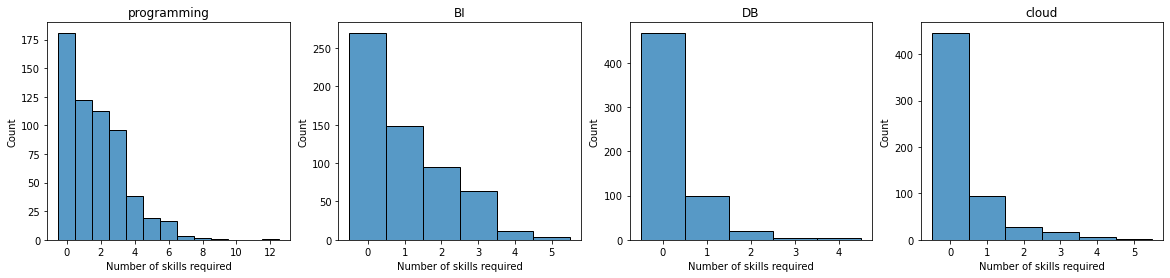

In [4]:
skill_dist = {
    "programming": [],
    "BI": [],
    "DB": [],
    "cloud": []
}

for doc in documents:
    for skill in skill_dist.keys():
        num_skills = 0
        if skill in doc:
            num_skills = len(doc[skill])
        skill_dist[skill].append(num_skills)

fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 4)
for idx, skill in enumerate(skill_dist.keys()):
    ax = axes[idx]
    sns.histplot(skill_dist[skill], ax=ax, discrete=True)
    ax.set_title(skill)
    ax.set_xlabel("Number of skills required")


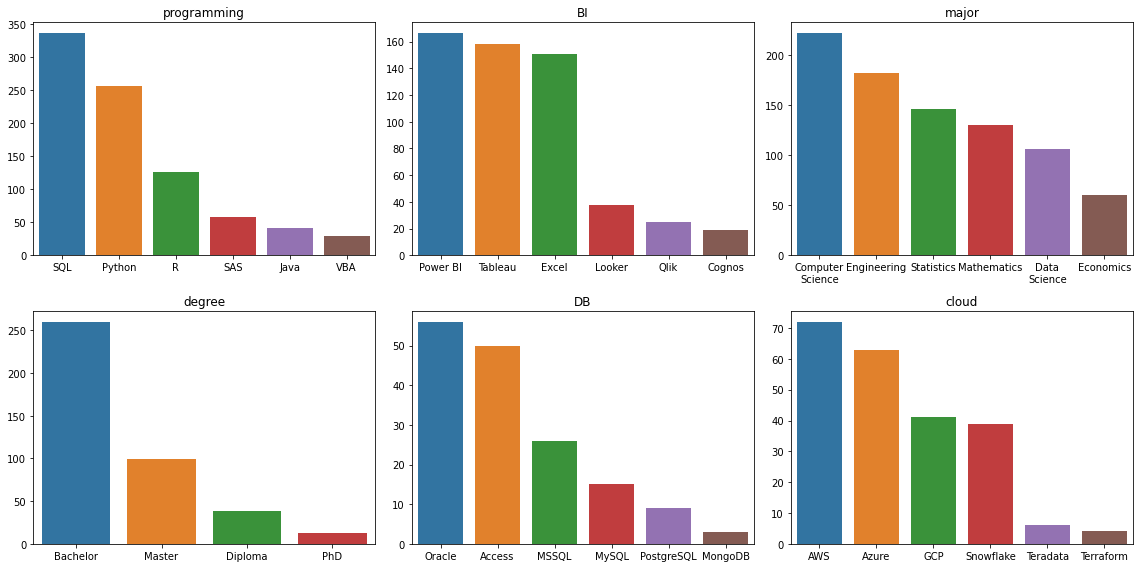

In [5]:
skill_set = {
    "programming": [],
    "BI": [],
    "major": [],
    "degree": [],
    "DB": [],
    "cloud": []
}

for item in documents:
    for key in skill_set.keys():
        if key not in item:
            continue
        skill_set[key].extend(item[key])
        
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(16, 8)
for idx, key in enumerate(skill_set.keys()):
    ax = axes[idx // 3][idx % 3]
    ax.set_title(key)
    c = dict(Counter(skill_set[key]).most_common(6))
    _x = list(map(lambda key: key.replace(" ", "\n") if len(key) > 8 else key, c.keys()))
    _y = list(c.values())
    sns.barplot(x=_x, y=_y, ax=ax)
fig.tight_layout()
plt.show()
    

In [6]:
def is_iterable(e):
    return isinstance(e, Iterable) and not isinstance(e, str)

def validate_filter(document: dict, filter: dict) -> bool:
    for key, val in filter.items():
        if key not in document:
            return False
        if is_iterable(val):
            for v in val:
                if v not in document[key]:
                    return False
        else:
            if val not in document[key]:
                return False
    return True

def count_documents_by_filter(documents: list, filter: dict) -> list:
    count = 0
    for doc in documents:
        valid = validate_filter(doc, filter)
        if valid:
            count += 1
    return count


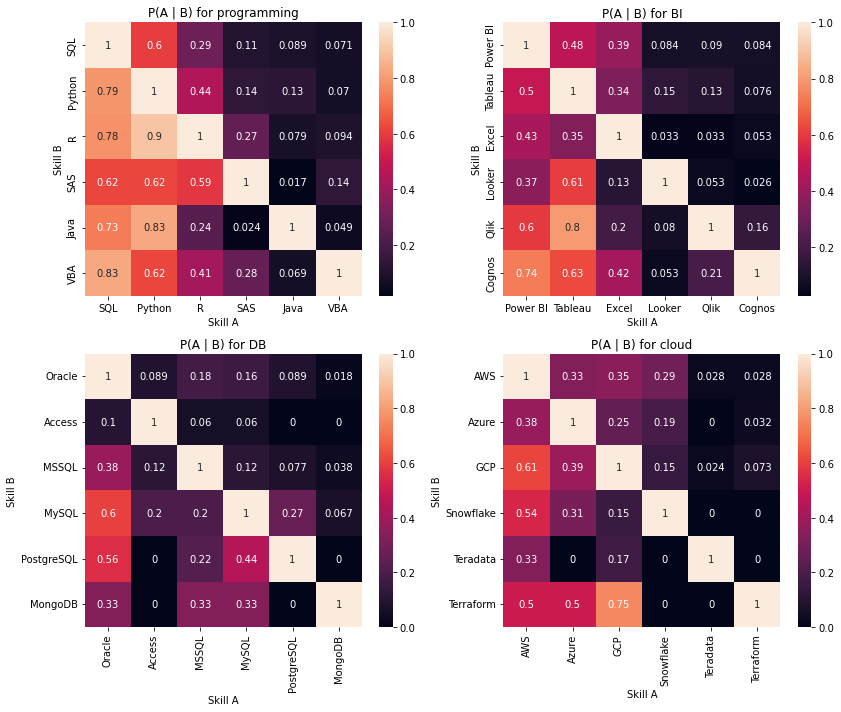

In [59]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
for idx, skill_cat in enumerate(skill_dist.keys()):
    ax = axes[idx // 2][idx % 2]
    c = dict(Counter(skill_set[skill_cat]).most_common(6)).keys()
    df = pd.DataFrame(columns=c, index=c)
    skill_pairs = combinations_with_replacement(c, 2)
    for pair in skill_pairs:
        A, B = pair
        N_A = count_documents_by_filter(documents, filter={skill_cat: A})
        N_B = count_documents_by_filter(documents, filter={skill_cat: B})
        N_AB = count_documents_by_filter(documents, filter={skill_cat: pair})
        df[B].loc[A] = N_AB/N_A
        df[A].loc[B] = N_AB/N_B
    sns.heatmap(df.astype(np.float32), ax=ax, annot=True)
    ax.set_title(f"P(A | B) for {skill_cat}")
    ax.set_xlabel("Skill A")
    ax.set_ylabel("Skill B")
fig.tight_layout()

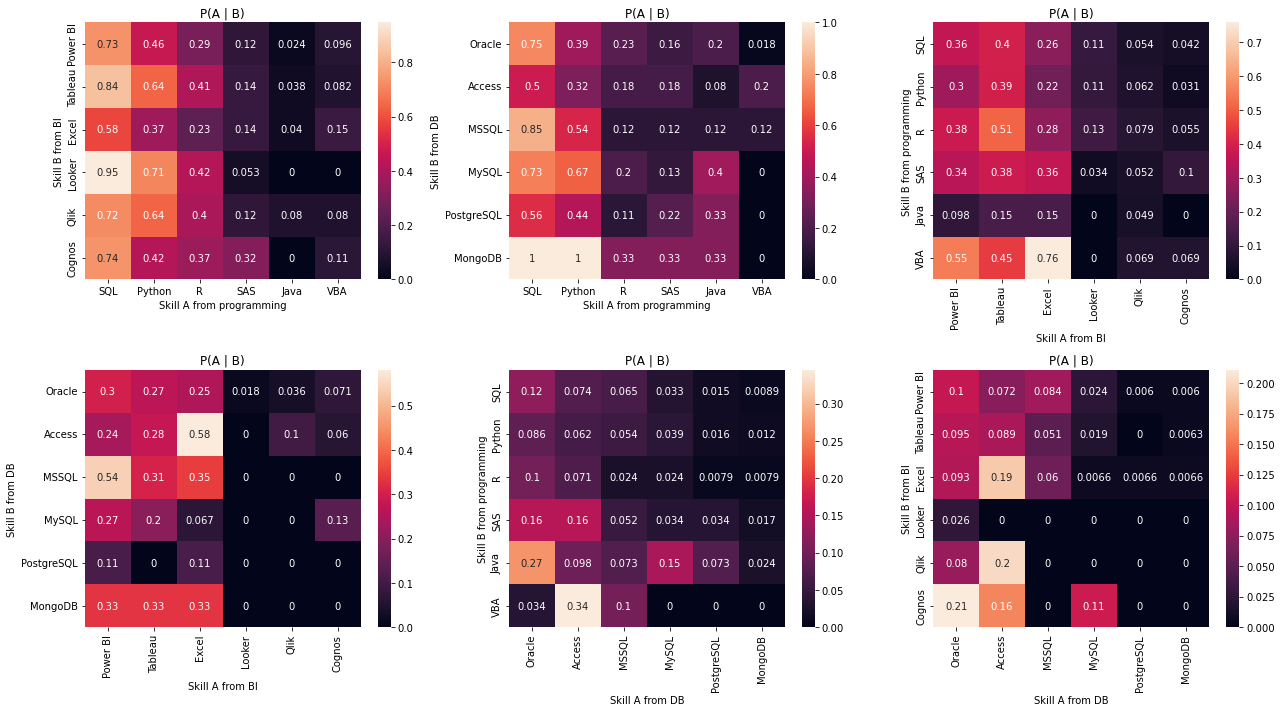

In [71]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(18, 10)
# cat_pairs = product(["programming", "BI", "DB"], ["programming", "BI", "DB"])
cat_pairs = combinations(["programming", "BI", "DB"], 2)
cat_pairs = permutations(["programming", "BI", "DB"], 2)
cat_pairs = [pair for pair in cat_pairs if pair[0] != pair[1]]
for idx, pair in enumerate(cat_pairs):
    ax = axes[idx // 3][idx % 3]
    catA, catB = pair
    kA = dict(Counter(skill_set[catA]).most_common(6)).keys()
    kB = dict(Counter(skill_set[catB]).most_common(6)).keys()
    skill_pairs = product(kA, kB)
    df = pd.DataFrame(columns=kA, index=kB)
    for pair in skill_pairs:
        A, B = pair
        N_A = count_documents_by_filter(documents, filter={catA: A})
        N_B = count_documents_by_filter(documents, filter={catB: B})
        N_AB = count_documents_by_filter(documents, filter={catA: A, catB: B})
        df[A].loc[B] = N_AB/N_B
    sns.heatmap(df.astype(np.float32), ax=ax, annot=True)
    ax.set_title(f"P(A | B)")
    ax.set_xlabel(f"Skill A from {catA}")
    ax.set_ylabel(f"Skill B from {catB}")
fig.tight_layout()
    